### URA - Telefones Fraudulentos

### Pacotes Utilizados

In [5]:
# Pouco blacklist - gerar muito falsos positivos
# 
# Packages
import pandas as pd
import numpy as np
import os
import warnings
from unicodedata import normalize
import matplotlib.pyplot as plt
import datetime as dt

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

### Leitura dos dados

In [3]:
df_ura_total = pd.read_excel('C:/Users/murilosr/Desktop/base/ura_crc_base.xlsx')

# Operations
# Base URA com replicatas - Tomar cuidado
# - aplicação se o connid é único
# - data do id


# connid - É único a partir da entrada do cliente em algum tipo de atendimento.
# loguraid - A cada ação do cliente temos um nova id.
# datahota -  A data e hora é acompanhada pelas ações do cliente. (log)
# aplicacao -  É CRC quando ele inicia um atendimento.
# * As outras variáveis são constantes


df_ura_total = df_ura_total[['connid','codsap','datahora', 'motivo','ddd','ani', 'aplicacao']]

In [4]:
# Estatística de missing
missing_values = missing_values_table(df_ura_total)
missing_values.head(5)
#df_ura_total = df_ura_total[df_ura_total['datahora'] >= '2019/04/01']

NameError: name 'missing_values_table' is not defined

In [ ]:
# Retirado observações em anonimo

df_ura_total = df_ura_total[df_ura_total['ani'] != 'anonymous']
#Na -> 0 
df_ura_total['ani'] = df_ura_total['ani'].fillna(0)
df_ura_total = df_ura_total[df_ura_total['ani'] != 0]

#df_ura_total = df_ura_total.fillna(0)
df_ura_total['ani'] = df_ura_total['ani'].astype('int64')

In [ ]:
df_ura_total['codsap'] = df_ura_total['codsap'].fillna(0)

### Removendo Inconsistências e leitura de bancos externos

In [ ]:
# Apenas telefones válidos
df_ura_total = df_ura_total[(df_ura_total['ani'] >= 1100000000) &  (df_ura_total['ani'] <= 99999999999)]

In [ ]:
# Ordenando os logs 
df_ura_total = df_ura_total.sort_values(['connid','datahora'])

In [ ]:
# 100 mil rows iguais
df_ura_total = df_ura_total.drop_duplicates()

# Transformando a v.a datahora para tipo Data
df_ura_total['datahora'] = df_ura_total['datahora'].apply(lambda x : pd.to_datetime(str(x)))
#df_ura_total['datahora'] = pd.to_datetime(df_ura_total['datahora'])

In [ ]:
# Criação blacklist

df_ura_total['ani'] = df_ura_total['ani'].astype(str)
df = pd.read_csv('C:/Users/murilosr/Desktop/base/Blacklist_telefones.csv',sep=';')
df['ani'] = df['ani'].astype(str)
#df = pd.read_csv('C:/Users/murilosr/Downloads/DB_engineered/Ura_blacklist.csv')
#df = df[['ani','Blacklist']]
#df.drop_duplicates(subset = 'connid')
#df = df.drop_duplicates(subset='connid')
df_ura_total = df_ura_total.merge(df, how = 'left', on = 'ani')
# df_ura_bk[df_ura_bk['connid'] == '006f02bfc71f8015']
df_ura_total = df_ura_total.fillna(0)
# Criação dos estados

df = pd.read_csv('C:/Users/murilosr/Documents/Votorantim/hackaton_analise/URA (utf-8, ddd com cidades).csv', sep = ',')
df  = df[['connid','Cidade_x', 'Estado_x']]
df = df.drop_duplicates(subset='connid')
df_ura_total = df_ura_total.merge(df, how = 'left', on = 'connid')

In [ ]:
# Tranformando as colunas em connid

df_pivot_motivos =  df_ura_total
df_pivot_motivos['frequencia'] = 1
df_pivot_motivos = pd.pivot_table(df_pivot_motivos, index='connid', columns='motivo', values='frequencia').rename(columns=str).reset_index()
df_pivot_motivos = df_pivot_motivos.fillna(0)

# Número de transições
df_pivot_motivos['numero_de_transicoes'] = df_pivot_motivos.iloc[: , 1:].sum(axis = 1)

### Criação de variáveis

In [ ]:
# Pegando apenas a data da v.a datahora
df_ura_total['data'] = df_ura_total['datahora'].dt.date
#df_ura_total['data'] = pd.to_datetime(df_ura_total['datahora']).apply(lambda x: x.date())
df_ura_total['ano'] = pd.DatetimeIndex(df_ura_total['data']).year
df_ura_total['mes'] = pd.DatetimeIndex(df_ura_total['data']).month
df_ura_total['dia'] = pd.DatetimeIndex(df_ura_total['data']).day
df_ura_total['semana_mes'] = df_ura_total['datahora'].apply(lambda d: (d.day-1) // 7 + 1)

# Transformando data para horas
df_ura_total['hora'] = df_ura_total['datahora'].dt.hour

In [ ]:
def periodo_dia(hour):
    return (
        "manha" if 5 <= hour <= 11
        else
        "tarde" if 12 <= hour <= 17
        else
        "noite" if 18 <= hour <= 0
        else
        "madrugada"
    )
df_ura_total['periodo'] = df_ura_total['hora'].apply(periodo_dia)

In [ ]:
# Intervalo delta das logs - segundos

df_ura_total['delta_connid'] = df_ura_total.sort_values(['connid','datahora']).groupby('connid')['datahora'].diff()
df_ura_total = df_ura_total.fillna(0)
#df['delta_hora'] = df[['delta_hora']].fillna(0)
#somando

df = df_ura_total.groupby('connid')['delta_connid'].sum().reset_index(name = 'delta_connid_sum')
df_ura_total = df_ura_total.merge(df, how = 'left', on ='connid')

In [ ]:
df_ura_total['delta_connid_sum'] = df_ura_total['delta_connid_sum'].dt.total_seconds()

In [ ]:
df_ura_total['delta_data'] = df_ura_total.sort_values(['ani','data']).groupby('ani')['data'].diff()
df_ura_total = df_ura_total.fillna('0 days 00:00:00')
df_ura_total['delta_data'] = df_ura_total['delta_data'].astype(str)
df_ura_total['delta_data'] = df_ura_total['delta_data'].replace(' days 00:00:00','', regex=True)
df_ura_total['delta_data'] = df_ura_total['delta_data'].astype(int)

# media
df = df_ura_total.groupby('ani')['delta_data'].mean().reset_index(name = 'delta')
df_ura_total = df_ura_total.merge(df, how = 'left', on ='ani')

In [ ]:
# Junção da tabela total da URA com o do motivos
df_ura_total = df_ura_total.merge(df_pivot_motivos, how = 'left', on ='connid')

In [ ]:
# Intervalo entre as ligações
# Variável flag (utilizou o sistema - entrada para todos os codsaps)
df_ura_total['flag_entrada'] = np.where(df_ura_total['aplicacao'] == 'CRC', 1, 0) # vai ser descartada

In [ ]:
# Contagem de ligação no dia pelo connid
df = df_ura_total[df_ura_total['flag_entrada'] == 1]

df = df[['connid','codsap','data','ani']].groupby(['ani','data'])['connid'].count().reset_index(name='contagem_ligacao_diaria')

df_ura_total = df_ura_total.merge(df, how = 'left', on = ['ani','data'])

# Contagem de codsap associado aquela ligação
    # No momento não realizar.

In [ ]:
#Número de codsap por telefone

df = df_ura_total.drop_duplicates(['ani','codsap']).groupby(['ani'])['codsap'].count().reset_index(name='contagem_de_codsap_por_telefone')
df_ura_total = df_ura_total.merge(df, how ='left', on = 'ani')                  

In [ ]:
#sem repetição dos logs
df_ura_total = df_ura_total.drop_duplicates(subset= 'connid')
df_ura_total['ani'] = df_ura_total['ani'].astype(str)

In [ ]:
# Quantas vezes o numero de telefone acessa o mesmo menu.

df_repeticao = df_ura_total.groupby(['ani','data'])['2_Cliente_optou_Pedido_Padrao',
 '2via_de_Boleto-ClienteNaoCadastrado',
 '2via_de_Boleto-EmailNaoLocalizado',
 '2via_de_Boleto-EnviadaComSucesso',
 '3_Cliente_optou_por_2via_de_Boleto',
 '4_Cliente_optou_por_Carregamento_do_Pedido',
 '5_Cliente_optou_por_Proximos_Pedidos',
 '6_Cliente_optou_Limite_Disponivel',
 '9_Cliente_optou_Humano-MenuFinalLimiteDisponivel',
 '9_Cliente_optou_por_Humano-MenuEncerramento',
 '9_Cliente_optou_por_Humano-MenuFinal2Via',
 '9_Cliente_optou_por_Humano-MenuFinalCarregtoPedido',
 '9_Cliente_optou_por_Humano-MenuFinalProximosPedido',
 '9_Cliente_optou_por_Humano-MenuPrincipal',
 'CarregamentoPedido-AguardandoPagamento',
 'CarregamentoPedido-ClienteNaoCadastrado',
 'CarregamentoPedido-EmailNaoLocalizado',
 'CarregamentoPedido-EmissaoNota',
 'CarregamentoPedido-EnvioViaEmail',
 'CarregamentoPedido-PedidoAgendado',
 'CarregamentoPedido-PedidoTransporte',
 'CarregamentoPedido-SeparacaoProduto',
 'ConsultarOutroCodigo-MenuFinalProximosPedidos',
 'DerivacaoIdentificado_PosVendas',
 'DerivacaoIdentificado_Vendas',
 'DerivacaoNaoIdentificado_PosVendas_TEC_POS',
 'DerivacaoNaoIdentificado_Vendas_TEC',
 'Derivacao_TAC_PosVendas',
 'EnvioParaRFC-2via',
 'EnvioParaRFC-CarregamentoPedido',
 'EnvioParaRFC-LimiteDisponivel',
 'EnvioParaRFC-ProximosPedidos',
 'F7_Cliente_optou_Fax',
 'F_Abandono-2Via_de_Boleto',
 'F_Abandono-CarregamentoPedido',
 'F_Abandono-LimiteDisponivel',
 'F_Abandono-ProximosPedidos',
 'F_AbandonoContingencia',
 'F_AbandonoDerivacao',
 'F_AbandonoHumano',
 'F_AbandonoMenuEncerramento',
 'F_AbandonoMenuFinal2Via',
 'F_AbandonoMenuFinalCarregamentoPedido',
 'F_AbandonoMenuFinalLimiteDisponivel',
 'F_AbandonoMenuFinalProximosPedidos',
 'F_AbandonoMenuPrincipal',
 'F_AbandonoSistemico-LimiteDisponivel',
 'F_AbandonoSistemicoRFC-2Via_de_Boleto',
 'F_AbandonoSistemicoRFC-CarregamentoPedido',
 'F_AbandonoSistemicoRFC-LimiteDisponivel',
 'F_AbandonoSistemicoRFC-ProximosPedidos',
 'F_Abandono_CRC',
 'F_CallBack',
 'F_DerivacaoFinal',
 'F_Fora_de_Horario_de_Atendimento',
 'F_Saiu_do_MenuEncerramento',
 'Inicio_de_Atendimento',
 'NovaSolicitacao-MenuFinal2Via',
 'ProximosPedidos-ClienteNaoCadastrado',
 'ProximosPedidos-ConsultouAte3Pedidos',
 'ProximosPedidos-EmailNaoLocalizado',
 'ProximosPedidos-EnvioViaEmail',
 'RetornoMenuAnterior-MenuFinal2Via',
 'RetornoMenuAnterior-MenuFinalCarregtoPedido',
 'RetornoMenuAnterior-MenuFinalLimiteDisponivel',
 'RetornoMenuAnterior-MenuFinalProximosPedidos',
 'Saiu_do_MenuFinal2Via',
 'Saiu_do_MenuFinalCarregamentoPedido',
 'Saiu_do_MenuImoAutoContrucao',
 'Saiu_do_MenuPrincipal',
 'Saiu_no_MenuCompras',
 '{out_motivo}'].size().reset_index(name = 'repeticao_menu')

In [ ]:
bk = df_ura_total

In [ ]:
df_ura_total = df_ura_total.merge(df_repeticao, on = ['ani','data'], how = 'left')

In [ ]:
df_ura_total = df_ura_total[['connid',
         'ddd', 
         'ani', 
         'Blacklist', 
         #'Cidade_x', 
         #'Estado_x', 
         #'data', 
         #'ano', 
         #'mes',
         #'dia', 
         #'semana_mes', 
         #'hora', 
         #'periodo', 
         'delta_connid_sum', 
         'delta',
         'numero_de_transicoes', 
         'contagem_ligacao_diaria', 
         'contagem_de_codsap_por_telefone',
         'repeticao_menu']]

In [ ]:
df_ura_total[['delta_connid_sum']] = df_ura_total[['delta_connid_sum']]/60
df_ura_total['numero_de_transicoes'] = df_ura_total['numero_de_transicoes'].astype(int)
#df_ura_total['contagem_ligacao_diaria'] = df_ura_total['contagem_ligacao_diaria'].astype(int)
df_ura_total['contagem_de_codsap_por_telefone'] = df_ura_total['contagem_de_codsap_por_telefone'].astype(int)
df_ura_total['delta'] = df_ura_total['delta'].astype(int)

### Comportamento individual de cada telefone - Ligações fora do contexto

In [ ]:
df_aux = df_ura_total[['ani','delta', 'contagem_de_codsap_por_telefone']].drop_duplicates()
df = df_ura_total.groupby('ani').agg({
                       'numero_de_transicoes':'mean', #numero de mudanças no menu
                       'delta_connid_sum':'mean', #media no tempo de ligação
                       #'contagem_de_codsap_por_telefone':'sum',
                       'contagem_ligacao_diaria':'mean',
                       'repeticao_menu':'mean'}).reset_index() #contagem de ligações daquele numero no periodo

df = df.merge(df_aux, on = 'ani', how = 'left')

df = df.rename(columns={'numero_de_transicoes':'media_numero_de_transicoes',
                       'delta_connid_sum':'media_de_tempo_na_linha', 
                       'contagem_de_codsap_por_telefone':'total_contagem_de_codsap_por_telefone',
                       'contagem_ligacao_diaria':'media_contagem_ligacao',
                       'repeticao_menu': 'media_repeticao_menu',
                       'delta': 'tempo_medio_de_ligacao'}).reset_index()

df_analise = df_ura_total[['ani','Blacklist']].drop_duplicates('ani')
df_analise = df_analise.merge(df, how = 'left', on = 'ani')
df_analise = df_analise.drop(['index'], axis = 1)
df_analise['Blacklist'] = df_analise['Blacklist'].astype(int)

### Análise Exploratória

In [ ]:
ax = df_analise['Blacklist'].value_counts().plot(kind = 'bar', 
                                                     facecolor='#FF8C00',
                                                     colormap = 'jet',
                                                     title='Frequência de Blacklist',figsize=(5,5))

ax.set(xlabel='Frequência de Blacklist', ylabel='Frequência')
plt.show();

#### Correlação entre as variáveis

In [564]:
df_analise.corr()

Blacklist  media_numero_de_transicoes  \
Blacklist                               1.000000                    0.002410   
media_numero_de_transicoes              0.002410                    1.000000   
media_de_tempo_na_linha                -0.015608                    0.650922   
media_contagem_ligacao                  0.081394                   -0.046471   
media_repeticao_menu                    0.067787                   -0.035660   
tempo_medio_de_ligacao                 -0.007146                   -0.011605   
total_contagem_de_codsap_por_telefone   0.021660                   -0.028214   

                                       media_de_tempo_na_linha  \
Blacklist                                            -0.015608   
media_numero_de_transicoes                            0.650922   
media_de_tempo_na_linha                               1.000000   
media_contagem_ligacao                               -0.092990   
media_repeticao_menu                                 -0.080586   
tempo_medio_de_ligacao                               -0.017518   
total_contagem_de_codsap_por_telefone                -0.065516   

                                       media_contagem_ligacao  \
Blacklist                                            0.081394   
media_numero_de_transicoes                          -0.046471   
media_de_tempo_na_linha                             -0.092990   
media_contagem_ligacao                               1.000000   
media_repeticao_menu                                 0.960955   
tempo_medio_de_ligacao                              -0.072388   
total_contagem_de_codsap_por_telefone                0.284967   

                                       media_repeticao_menu  \
Blacklist                                          0.067787   
media_numero_de_transicoes                        -0.035660   
media_de_tempo_na_linha                           -0.080586   
media_contagem_ligacao                             0.960955   
media_repeticao_menu                               1.000000   
tempo_medio_de_ligacao                            -0.071814   
total_contagem_de_codsap_por_telefone              0.298554   

                                       tempo_medio_de_ligacao  \
Blacklist                                           -0.007146   
media_numero_de_transicoes                          -0.011605   
media_de_tempo_na_linha                             -0.017518   
media_contagem_ligacao                              -0.072388   
media_repeticao_menu                                -0.071814   
tempo_medio_de_ligacao                               1.000000   
total_contagem_de_codsap_por_telefone                0.068352   

                                       total_contagem_de_codsap_por_telefone  
Blacklist                                                           0.021660  
media_numero_de_transicoes                                         -0.028214  
media_de_tempo_na_linha                                            -0.065516  
media_contagem_ligacao                                              0.284967  
media_repeticao_menu                                                0.298554  
tempo_medio_de_ligacao                                              0.068352  
total_contagem_de_codsap_por_telefone                               1.000000

#### Distribuições das variáveis

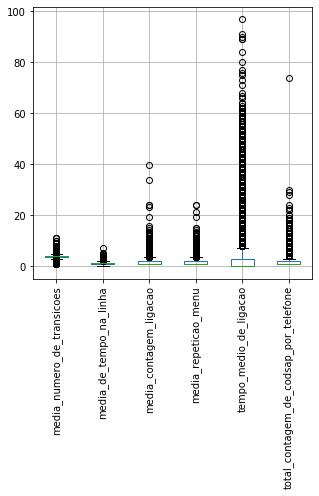

In [565]:
import math 
#Realização de alguns boxplots
df_analise.iloc[:,2:].boxplot(figsize=(5,5))
plt.xticks(rotation=90)
plt.show()

#### Descritivos das variáveis

In [566]:
df_analise.iloc[:,2:].describe()

media_numero_de_transicoes  media_de_tempo_na_linha  \
count                37743.000000             37743.000000   
mean                     3.842243                 1.084161   
std                      0.889907                 0.456991   
min                      1.000000                 0.000000   
25%                      3.529412                 0.800352   
50%                      4.000000                 1.066373   
75%                      4.000000                 1.350000   
max                     11.000000                 7.239392   

       media_contagem_ligacao  media_repeticao_menu  tempo_medio_de_ligacao  \
count            37467.000000          37743.000000            37743.000000   
mean                 1.595758              1.584410                3.513976   
std                  1.032523              0.985009                7.747725   
min                  1.000000              1.000000                0.000000   
25%                  1.000000              1.000000                0.000000   
50%                  1.000000              1.000000                0.000000   
75%                  2.000000              2.000000                3.000000   
max                 39.693878             23.941176               97.000000   

       total_contagem_de_codsap_por_telefone  
count                           37743.000000  
mean                                1.580849  
std                                 1.192320  
min                                 1.000000  
25%                                 1.000000  
50%                                 1.000000  
75%                                 2.000000  
max                                74.000000

In [ ]:
import seaborn as sns
sns.pairplot(df_analise.iloc[:,2:], hue='Blacklist', size=2);

### Olhando a Kernel de distribuição

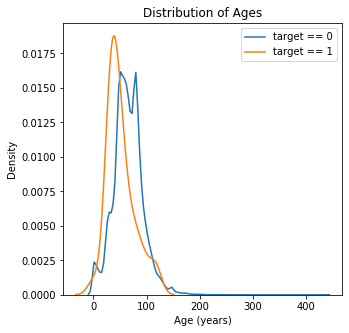

In [361]:
plt.figure(figsize = (5, 5))

# KDE plot of loans that were repaid on time
sns.kdeplot(df_analise.loc[df_analise['Blacklist'] == 0, 'media_delta_connid'], label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(df_analise.loc[df_analise['Blacklist'] == 1, 'media_delta_connid'] , label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

## Modelagem

### Divisão de treino, teste

In [682]:
X = df_analise.drop(['ani','Blacklist'], axis = 1) #Removendo a variavel resposta
y = df_analise['Blacklist'].values #pegando a variável resposta
y = y.astype(int) #Transformando para inteiro

In [683]:
X = X.fillna(0)

In [672]:
#from sklearn.preprocessing import MinMaxScaler 
#scaler = MinMaxScaler()
#X = scaler.fit_transform(X)

In [684]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.30, 
                                                    random_state=24, 
                                                    stratify = y)

In [685]:
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state = 24)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Acurácia do teste: %.4f' % clf.score(X_test, y_test))

Acurácia do teste: 0.9981


In [686]:
# Tabela de resultados
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11312
           1       0.18      0.27      0.21        11

    accuracy                           1.00     11323
   macro avg       0.59      0.64      0.61     11323
weighted avg       1.00      1.00      1.00     11323



### ADASYN Técnica

In [687]:
from imblearn.over_sampling import SMOTE, ADASYN
X_ada, y_ada = ADASYN().fit_resample(X, y)

#X_ada = scaler.fit_transform(X_ada)

In [688]:
### Plotagem da transformação adasyn()

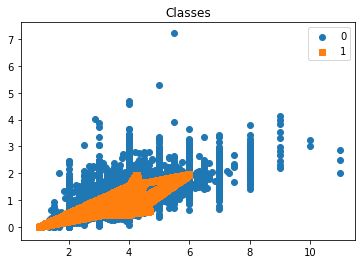

In [689]:
plot_2d_space(X_ada, y_ada)

In [690]:
from sklearn.model_selection import train_test_split
X_train_ada, X_test_ada, y_train_ada, y_test_ada = train_test_split(X_ada, y_ada, 
                                                    test_size=0.30, 
                                                    random_state=24, 
                                                    stratify = y_ada)

### Definindo o modelo a ser usado

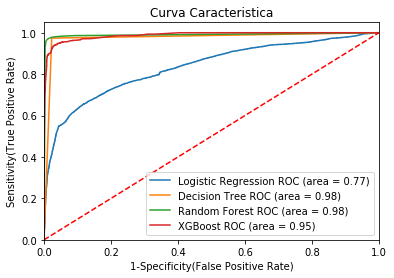

In [691]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

plt.figure()

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(),
},
{
    'label': 'Decision Tree',
    'model':  DecisionTreeClassifier(),
},
{
    'label': 'Random Forest',
    'model': RandomForestClassifier(),
},        
{
    'label': 'XGBoost',
    'model': XGBClassifier(),
},    
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train_ada, y_train_ada) # train the model
    y_pred=model.predict(X_test_ada) # predict the test data
    
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test_ada, model.predict_proba(X_test_ada)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test_ada, model.predict(X_test_ada))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Curva Caracteristica')
plt.legend(loc="lower right")
plt.show()

### Escolha do modelo

In [693]:
rf = RandomForestClassifier(max_depth=4, random_state = 24)

rf.fit(X_train_ada, y_train_ada)
y_pred_ada = rf.predict(X_test_ada)
print('Acurácia do teste: %.4f' % rf.score(X_test_ada, y_test_ada))

Acurácia do teste: 0.8830


In [694]:
# Tabela de resultados
from sklearn.metrics import classification_report
print(classification_report(y_test_ada, y_pred_ada))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88     11313
           1       0.89      0.87      0.88     11310

    accuracy                           0.88     22623
   macro avg       0.88      0.88      0.88     22623
weighted avg       0.88      0.88      0.88     22623



### Cross-Validation - Olhando para a perfomance do modelo

In [697]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator = rf,
                        X = X_train_ada,
                        y = y_train_ada,
                        cv = 10,
                        n_jobs =-1)
print('Média:', np.mean(scores))
print('DP: ', np.std(scores))

Média: 0.8834303500159102
DP:  0.004874898944289879


### Validation Curve - Olhando para o bias e Variância

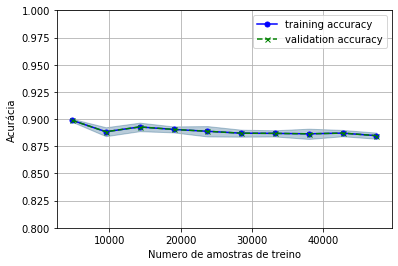

In [699]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = \
                learning_curve(estimator = rf,
                              X = X_train_ada,
                              y = y_train_ada,
                              train_sizes = np.linspace(0.1,1.0,10),
                              cv = 10,
                              n_jobs = 1)

train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(train_scores, axis = 1)
test_std = np.std(train_scores, axis = 1)

plt.plot(train_sizes, train_mean, 
                 color = 'blue', 
                 marker = 'o', markersize = 5, 
                 label = 'training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std, 
                 alpha = 0.15, color = 'blue')

plt.plot(train_sizes, test_mean,
                 color ='green', linestyle ='--',
                 marker = 'x', markersize =5,
                 label = 'validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha = 0.15, color = 'green')

plt.grid()
plt.xlabel('Numero de amostras de treino')
plt.ylabel('Acurácia')
plt.legend(loc ='lower_right')
plt.ylim([0.8,1])
plt.show()

In [700]:
### Tuning Hyperparameters

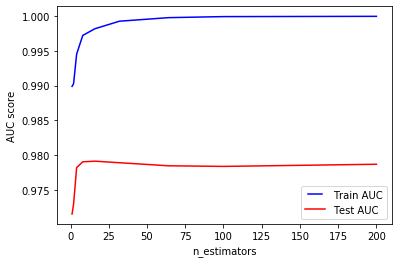

In [702]:
from sklearn.metrics import roc_curve, auc
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []

for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(X_train_ada, y_train_ada)
    train_pred = rf.predict(X_train_ada)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_ada, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test_ada)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_ada, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

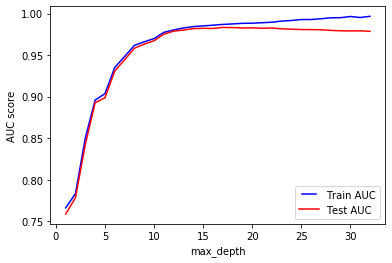

In [705]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
    rf.fit(X_train_ada, y_train_ada)
    train_pred = rf.predict(X_train_ada)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_ada, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test_ada)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_ada, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max_depth')
plt.show()

In [709]:
rf = RandomForestClassifier(n_estimators = 16,
                            max_depth=11, random_state = 24)

rf.fit(X_train_ada, y_train_ada)
y_pred_ada = rf.predict(X_test_ada)
print('Acurácia do teste: %.4f' % rf.score(X_test_ada, y_test_ada))

Acurácia do teste: 0.9754


In [710]:
# Tabela de resultados
from sklearn.metrics import classification_report
print(classification_report(y_test_ada, y_pred_ada))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     11313
           1       0.99      0.96      0.98     11310

    accuracy                           0.98     22623
   macro avg       0.98      0.98      0.98     22623
weighted avg       0.98      0.98      0.98     22623



### Resultados do Modelo

#### Matriz de confusão

Confusion matrix:
 [[11179   134]
 [  423 10887]]


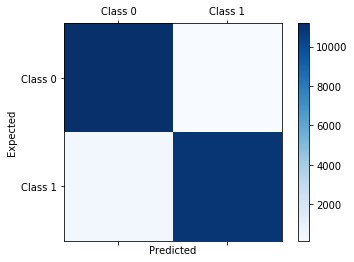

In [711]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_test_ada, y_pred=y_pred_ada)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

### Teste do modelo

In [738]:
df_analise[df_analise['Blacklist'] == 1].head(10)

ani  Blacklist  media_numero_de_transicoes  \
767    86999868261          1                    3.794118   
1743   12996735737          1                    4.500000   
5276    1122047333          1                    4.000000   
7949    2226242891          1                    4.000000   
9470    3333361146          1                    4.600000   
10588  82988863926          1                    4.500000   
12515  24992274170          1                    3.800000   
12657  94992015006          1                    4.250000   
13157  99991061358          1                    3.750000   
18028  27998327736          1                    3.965517   

       media_de_tempo_na_linha  media_contagem_ligacao  media_repeticao_menu  \
767                   1.404454                7.117647              7.117647   
1743                  0.791667                2.000000              2.000000   
5276                  0.610720                3.250000              3.250000   
7949                  0.866667                1.000000              1.000000   
9470                  0.773333                5.000000              5.000000   
10588                 1.665058                1.000000              1.000000   
12515                 0.856667                5.200000              2.600000   
12657                 1.066667                1.000000              1.000000   
13157                 1.050000                1.500000              1.500000   
18028                 0.665517                6.724138              6.724138   

       tempo_medio_de_ligacao  total_contagem_de_codsap_por_telefone  
767                         2                                      5  
1743                        0                                      2  
5276                        3                                      3  
7949                        0                                      1  
9470                        0                                      2  
10588                      37                                      1  
12515                       0                                      2  
12657                       2                                      3  
13157                       0                                      2  
18028                       0                                      1

In [739]:
df_analise[df_analise['Blacklist'] == 0].head(10)

ani  Blacklist  media_numero_de_transicoes  \
0   1145724669          0                    2.000000   
1  41999884000          0                    2.571429   
2  82994121423          0                    3.896552   
3   6533121132          0                    4.000000   
4   5130437238          0                    3.000000   
5  85986704067          0                    2.750000   
6   5137151888          0                    3.625000   
7  21980391524          0                    3.333333   
8   6536676000          0                    4.000000   
9   8532833945          0                    3.200000   

   media_de_tempo_na_linha  media_contagem_ligacao  media_repeticao_menu  \
0                 0.261111                3.000000              3.000000   
1                 1.158969                2.142857              2.142857   
2                 0.958046                2.793103              2.793103   
3                 1.438347                3.615385              3.615385   
4                 1.283333                3.000000              3.000000   
5                 0.566667                6.250000              6.250000   
6                 0.999869                4.750000              4.750000   
7                 0.805556                3.000000              3.000000   
8                 1.485535                2.619048              2.619048   
9                 0.876667                2.000000              1.800000   

   tempo_medio_de_ligacao  total_contagem_de_codsap_por_telefone  
0                       0                                      2  
1                      17                                      6  
2                       0                                      3  
3                       7                                      2  
4                       0                                      2  
5                       2                                      2  
6                       9                                      2  
7                       0                                      2  
8                       4                                      3  
9                      19                                      1

In [775]:
df_analise[df_analise['ani']=='	27998327736'].drop(['Blacklist'], axis = 1)

ani  media_numero_de_transicoes  media_de_tempo_na_linha  \
767  86999868261                    3.794118                 1.404454   

     media_contagem_ligacao  media_repeticao_menu  tempo_medio_de_ligacao  \
767                7.117647              7.117647                       2   

     total_contagem_de_codsap_por_telefone  
767                                      5

In [778]:
#teste = np.array([[4, 3, 12, 23,23, 2]])
teste  =df_analise[df_analise['ani']=='27998327736'].drop(['ani','Blacklist'], axis = 1)

In [779]:
rf.predict_proba(teste)

array([[0.01418193, 0.98581807]])

In [759]:

#teste = teste.drop(['ani','Blacklist'], axis = 1).values
result = rf.predict(teste)
if result == 1:
    print('Alerta')
else:
    print('Sem alerta')

ValueError: Number of features of the model must match the input. Model n_features is 6 and input n_features is 8 

In [1]:
rf.feature_importances_

NameError: name 'rf' is not defined

In [ ]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [749]:
teste

array([[3.33333333, 0.80555556, 3.        , 3.        , 0.        ,
        2.        ]])

### Clusterização K-means

In [108]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

In [178]:
X = base[['media_delta_connid','repeticao_menu']].values

In [179]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

Text(0, 0.5, 'WCSS')

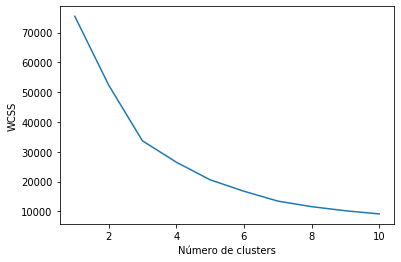

In [180]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, random_state = 0, init = 'k-means++')
    kmeans.fit(X_std)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')

In [181]:
kmeans = KMeans(n_clusters = 6, random_state = 0, init = 'k-means++')
previsoes = kmeans.fit_predict(X_std)

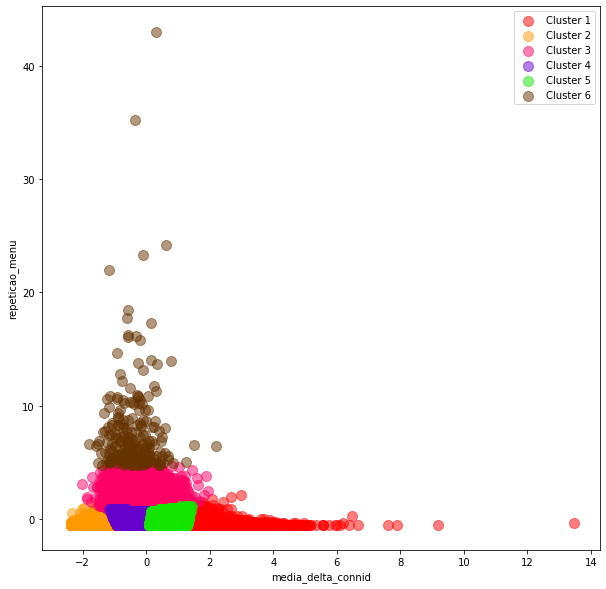

In [402]:
plt.figure(figsize=(10,10))
plt.scatter(X_std[previsoes == 0, 0], X_std[previsoes == 0, 1], s = 100, c = 'red', label = 'Cluster 1',  alpha=0.5)
plt.scatter(X_std[previsoes == 1, 0], X_std[previsoes == 1, 1], s = 100, c = '#ff9900', label = 'Cluster 2',  alpha=0.5)
plt.scatter(X_std[previsoes == 2, 0], X_std[previsoes == 2, 1], s = 100, c = '#ff0066', label = 'Cluster 3',  alpha=0.5)
plt.scatter(X_std[previsoes == 3, 0], X_std[previsoes == 3, 1], s = 100, c = '#6600cc', label = 'Cluster 4',  alpha=0.5)
plt.scatter(X_std[previsoes == 4, 0], X_std[previsoes == 4, 1], s = 100, c = '#14e600', label = 'Cluster 5',  alpha=0.5)
plt.scatter(X_std[previsoes == 5, 0], X_std[previsoes == 5, 1], s = 100, c = '#663300', label = 'Cluster 6',  alpha=0.5)

plt.xlabel('media_delta_connid')
plt.ylabel('repeticao_menu')
plt.legend()
plt.show() 

In [401]:
df_ura_total[df_ura_total['Blacklist']== 1] #37 -<> 37000 (nao fraudador)

connid     codsap            datahora  \
5215    007802bfaff35513  1366709.0 2018-06-01 08:45:08   
5347    007802bfaff3553c  1366709.0 2018-06-01 08:46:37   
5573    007802bfaff3557c  1366709.0 2018-06-01 08:49:04   
6539    007802bfaff356bb        0.0 2018-06-01 08:59:47   
6734    007802bfaff356f7  1366709.0 2018-06-01 09:01:20   
...                  ...        ...                 ...   
711214  007902c4e0d4c34b        0.0 2018-08-06 09:20:42   
716155  007902c4e0d4e9d6        0.0 2018-08-06 16:56:57   
717999  007902c4e0d4f554        0.0 2018-08-07 09:19:47   
721995  007902c649c4d34e  1294865.0 2018-08-08 16:22:53   
722580  007902c649c4dce9  1294865.0 2018-08-08 17:27:00   

                       motivo  ddd          ani aplicacao  Blacklist  \
5215    Inicio_de_Atendimento   86  86999868261       CRC        1.0   
5347    Inicio_de_Atendimento   86  86999868261       CRC        1.0   
5573    Inicio_de_Atendimento   86  86999868261       CRC        1.0   
6539    Inicio_de_Atendimento   86  86999868261       CRC        1.0   
6734    Inicio_de_Atendimento   86  86999868261       CRC        1.0   
...                       ...  ...          ...       ...        ...   
711214  Inicio_de_Atendimento   11  11940737472       CRC        1.0   
716155  Inicio_de_Atendimento   11  11940737472       CRC        1.0   
717999  Inicio_de_Atendimento   11  11940737472       CRC        1.0   
721995  Inicio_de_Atendimento   82  82998276469       CRC        1.0   
722580  Inicio_de_Atendimento   82  82998276469       CRC        1.0   

           Cidade_x Estado_x  frequencia        data   ano  mes  dia  \
5215      Teresina        PI           1  2018-06-01  2018    6    1   
5347      Teresina        PI           1  2018-06-01  2018    6    1   
5573      Teresina        PI           1  2018-06-01  2018    6    1   
6539      Teresina        PI           1  2018-06-01  2018    6    1   
6734      Teresina        PI           1  2018-06-01  2018    6    1   
...             ...      ...         ...         ...   ...  ...  ...   
711214   São Paulo        SP           1  2018-08-06  2018    8    6   
716155   São Paulo        SP           1  2018-08-06  2018    8    6   
717999   São Paulo        SP           1  2018-08-07  2018    8    7   
721995      Maceió        AL           1  2018-08-08  2018    8    8   
722580      Maceió        AL           1  2018-08-08  2018    8    8   

        semana_mes  hora periodo delta_connid  delta_connid_sum  delta_data  \
5215             1     8   manha       0 days              56.0           0   
5347             1     8   manha       0 days              45.0           0   
5573             1     8   manha       0 days             172.0           0   
6539             1     8   manha       0 days              24.0           0   
6734             1     9   manha       0 days             208.0           0   
...            ...   ...     ...          ...               ...         ...   
711214           1     9   manha       0 days              61.0           4   
716155           1    16   tarde       0 days              49.0           0   
717999           1     9   manha       0 days              53.0           1   
721995           2    16   tarde       0 days              28.0           0   
722580           2    17   tarde       0 days              28.0           0   

            delta  2_Cliente_optou_Pedido_Padrao  \
5215     2.682171                            0.0   
5347     2.682171                            0.0   
5573     2.682171                            1.0   
6539     2.682171                            0.0   
6734     2.682171                            1.0   
...           ...                            ...   
711214   0.259259                            0.0   
716155   0.259259                            0.0   
717999   0.259259                            0.0   
721995  16.000000                            0.0   
722580  16.000000                            0.0   

     

### Clusters x Outliers

In [215]:
# Identificando os clusters extremos

clustered = pd.concat([base_X[['ani','Blacklist']], pd.DataFrame({'X_std1':X_std[:,0], 'X_std2':X_std[:,1]}), pd.DataFrame({'group':previsoes})], axis = 1)

In [216]:
clustered[clustered['Blacklist'] == 1]['group'].value_counts()

2    12
3    11
1     6
4     3
5     2
0     2
Name: group, dtype: int64

In [225]:
clustered[clustered['X_std2'] >=8]['Blacklist'].value_counts()

0.0    69
Name: Blacklist, dtype: int64

### Regra Blacklist

In [477]:
df_ref = df_analise[df_analise['Blacklist'] == 1].groupby('Blacklist').agg({'delta':'mean',
                                                                   'media_numero_de_transicoes':'mean',
                                                                   'media_delta_connid': 'mean',
                                                                   'total_contagem_de_codsap_por_telefone':'mean',
                                                                   'total_contagem_ligacao':'mean',
                                                                   'repeticao_menu':'mean'})

In [479]:
df_ref = df_ref.reset_index()

In [558]:
df_ref

Blacklist     delta  media_numero_de_transicoes  media_delta_connid  \
0        1.0  1.904687                    3.911645           51.199469   

   total_contagem_de_codsap_por_telefone  total_contagem_ligacao  \
0                              58.138889              105.361111   

   repeticao_menu  
0       14.083333

In [644]:
df_bk.iloc[1:2,3:]

delta  media_numero_de_transicoes  media_delta_connid  \
1743    0.0                         4.5                47.5   

      total_contagem_de_codsap_por_telefone  total_contagem_ligacao  \
1743                                      4                     4.0   

      repeticao_menu  
1743               2

In [714]:
def funcao_dist (x):
    aux = 0
    media =list()
    df_bk = df_analise[df_analise['Blacklist']==1]
    df_nbk = df_analise[df_analise['Blacklist']==0]
    from scipy.spatial import distance
    for j in range(1, 1000):
        aux = 0
        for i in range(1,len(df_bk)):
            dist = distance.cdist(df_bk.iloc[j-1:j,3:], df_bk.iloc[i-1:i,3:], metric='euclidean')
            aux = aux + dist
        dist_media = aux/len(df_bk)
        media.append(dist_media)
        print(media)
    return(media)
    # return(dist)
    #raio = 2
    #if dist > raio:
    #    blacklist = 0
    #    return(blacklist)
    #else:
    #    blacklist = 1
    #    return(blacklist)

In [718]:
df_analise

ani  ddd  Blacklist      delta  media_numero_de_transicoes  \
0       1145724669   11        0.0   0.000000                    2.000000   
1      41999884000   41        0.0  17.444444                    2.571429   
2      82994121423   82        0.0   0.592920                    3.896552   
3       6533121132   65        0.0   7.230769                    4.000000   
4       5130437238   51        0.0   0.000000                    3.000000   
...            ...  ...        ...        ...                         ...   
37738   7436611752   74        0.0   0.000000                    4.000000   
37739  75991651880   75        0.0   0.000000                    4.000000   
37740  11984910562   11        0.0   0.000000                    2.500000   
37741   1136542030   11        0.0   0.000000                    3.000000   
37742  81996558975   81        0.0   0.000000                    7.000000   

       media_delta_connid  total_contagem_de_codsap_por_telefone  \
0               15.666667                                      6   
1               69.538143                                     42   
2               57.482759                                     87   
3               86.300846                                     26   
4               77.000000                                      6   
...                   ...                                    ...   
37738           71.000000                                      2   
37739           95.000000                                      1   
37740           19.500000                                      4   
37741           27.000000                                      1   
37742          110.000000                                      1   

       total_contagem_ligacao  repeticao_menu  
0                         9.0               3  
1                        15.0               7  
2                        81.0              29  
3                        47.0              13  
4                         9.0               3  
...                       ...             ...  
37738                     4.0               2  
37739                     1.0               1  
37740                     4.0               2  
37741                     1.0               1  
37742                     1.0               1  

[37743 rows x 9 columns]

In [713]:
(110+120+230)/3

153.33333333333334

In [593]:
distance.cdist(df_bk.iloc[:5,3:], df_bk.iloc[:5,3:], metric='euclidean')

array([[294.7243643 ,  32.39770225, 135.71771876,  37.64453627,
         35.03281002]])

In [584]:
distance.cdist(df_analise.iloc[:0,3:], df_bk.iloc[:0,3:], metric='euclidean')

ani  ddd  Blacklist      delta  media_numero_de_transicoes  \
767    86999868261   86        1.0   2.682171                    3.794118   
1743   12996735737   12        1.0   0.000000                    4.500000   
5276    1122047333   11        1.0   3.046875                    4.000000   
7949    2226242891   22        1.0   0.000000                    4.000000   
9470    3333361146   33        1.0   0.000000                    4.600000   
10588  82988863926   82        1.0  37.111111                    4.500000   
12515  24992274170   24        1.0   0.236842                    3.800000   
12657  94992015006   94        1.0   2.647059                    4.250000   
13157  99991061358   99        1.0   0.333333                    3.750000   
18028  27998327736   27        1.0   0.060870                    3.965517   
19375  11940737472   11        1.0   0.259259                    3.857143   
21916  11977940495   11        1.0   0.000000                    6.000000   
22765  11960554846   11        1.0   0.000000                    4.000000   
22851  82991187475   82        1.0   1.312500                    3.692308   
22899   3333323471   33        1.0   0.633333                    2.900000   
22999  33984094733   33        1.0   1.566667                    2.500000   
23705   3333313338   33        1.0   0.000000                    1.000000   
24204  27988514254   27        1.0   0.440000                    3.880000   
24468  82998276469   82        1.0  16.000000                    3.400000   
24551  81993190069   81        1.0   0.253165                    3.950000   
25184  33984043607   33        1.0   0.031250                    4.000000   
25212  33984540221   33        1.0   0.238095                    3.937500   
25320  33984316308   33        1.0   0.104167                    3.789474   
25683  24988061519   24        1.0   0.134615                    4.160000   
26753  11977989391   11        1.0   0.125000                    4.000000   
27161  61984917828   61        1.0   0.058824                    4.250000   
27686  81983499336   81        1.0   0.113636                    3.826087   
28771  22988363279   22        1.0   0.060086                    4.163636   
30016  33984561727   33        1.0   0.083333                    4.000000   
30240  33984620240   33        1.0   0.218750                    4.000000   
30894  27988047724   27        1.0   0.074468                    4.694915   
32667  81979108634   81        1.0   0.166667                    4.000000   
32716  81982475227   81        1.0   0.166667                    4.000000   
32749  81995000047   81        1.0   0.160000                    3.658537   
32753  81981688232   81        1.0   0.250000                    4.000000   
36967  85981665322   85        1.0   0.000000                    4.000000   

       media_delta_connid  total_contagem_de_codsap_por_telefone  \
767             84.267235                                    170   
1743            47.500000                                      4   
5276            36.643219                                     96   
7949            52.000000                                      1   
9470            46.400000                                     10   
10588           99.903500                                      2   
12515           51.400000                                     10   
12657           64.000000                                     12   
13157           63.000000                                      8   
18028           39.931034                                     29   
19375           50.380952                                     42   
21916          118.000000                                      1   
22765           27.000000                                      2   
22851           47.339000                                     13   
22899           58.509400                                     10   
22999           26.887833                                      6   
23705    

In [579]:
df_bk

NameError: name 'df_bk' is not defined

In [547]:
df = pd.DataFrame(a)

In [557]:
df[df[0] < 20]

0
139    16.969402
979    19.385327
1108   18.399448
2353   16.922442
4825   18.511101
5905   18.628193
9402   18.958768
11608  19.963695
12436  19.724761
18192  15.644946
20110  17.265489
26067  11.742448
27642  18.597508
34740  19.049380
36259  15.659003

In [556]:
df_analise[df_analise['Blacklist'] == 1]

ani  ddd  Blacklist      delta  media_numero_de_transicoes  \
767    86999868261   86        1.0   2.682171                    3.794118   
1743   12996735737   12        1.0   0.000000                    4.500000   
5276    1122047333   11        1.0   3.046875                    4.000000   
7949    2226242891   22        1.0   0.000000                    4.000000   
9470    3333361146   33        1.0   0.000000                    4.600000   
10588  82988863926   82        1.0  37.111111                    4.500000   
12515  24992274170   24        1.0   0.236842                    3.800000   
12657  94992015006   94        1.0   2.647059                    4.250000   
13157  99991061358   99        1.0   0.333333                    3.750000   
18028  27998327736   27        1.0   0.060870                    3.965517   
19375  11940737472   11        1.0   0.259259                    3.857143   
21916  11977940495   11        1.0   0.000000                    6.000000   
22765  11960554846   11        1.0   0.000000                    4.000000   
22851  82991187475   82        1.0   1.312500                    3.692308   
22899   3333323471   33        1.0   0.633333                    2.900000   
22999  33984094733   33        1.0   1.566667                    2.500000   
23705   3333313338   33        1.0   0.000000                    1.000000   
24204  27988514254   27        1.0   0.440000                    3.880000   
24468  82998276469   82        1.0  16.000000                    3.400000   
24551  81993190069   81        1.0   0.253165                    3.950000   
25184  33984043607   33        1.0   0.031250                    4.000000   
25212  33984540221   33        1.0   0.238095                    3.937500   
25320  33984316308   33        1.0   0.104167                    3.789474   
25683  24988061519   24        1.0   0.134615                    4.160000   
26753  11977989391   11        1.0   0.125000                    4.000000   
27161  61984917828   61        1.0   0.058824                    4.250000   
27686  81983499336   81        1.0   0.113636                    3.826087   
28771  22988363279   22        1.0   0.060086                    4.163636   
30016  33984561727   33        1.0   0.083333                    4.000000   
30240  33984620240   33        1.0   0.218750                    4.000000   
30894  27988047724   27        1.0   0.074468                    4.694915   
32667  81979108634   81        1.0   0.166667                    4.000000   
32716  81982475227   81        1.0   0.166667                    4.000000   
32749  81995000047   81        1.0   0.160000                    3.658537   
32753  81981688232   81        1.0   0.250000                    4.000000   
36967  85981665322   85        1.0   0.000000                    4.000000   

       media_delta_connid  total_contagem_de_codsap_por_telefone  \
767             84.267235                                    170   
1743            47.500000                                      4   
5276            36.643219                                     96   
7949            52.000000                                      1   
9470            46.400000                                     10   
10588           99.903500                                      2   
12515           51.400000                                     10   
12657           64.000000                                     12   
13157           63.000000                                      8   
18028           39.931034                                     29   
19375           50.380952                                     42   
21916          118.000000                                      1   
22765           27.000000                                      2   
22851           47.339000                                     13   
22899           58.509400                                     10   
22999           26.887833                                      6   
23705    

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000264C8488988>,
      dtype=object)

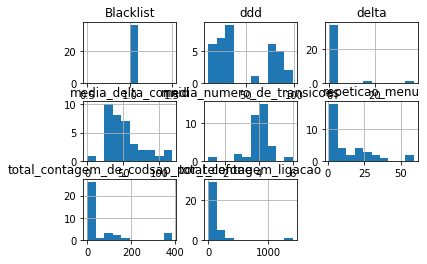

In [717]:
df_analise[df_analise['Blacklist'] == 1].hist()

In [375]:
def missing_values_table(df):
        # Total de valores missing
        mis_val = df.isnull().sum()
        
        # Porcentagem de valores missing
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Tabela de resultados
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Renomear colunas
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Valores Faltantes', 1 : '% de Valores no Total'})
        
        # Retornar a informação de missing em um dataframe
        return mis_val_table_ren_columns.sort_values('% de Valores no Total', ascending=False).round(1)

In [645]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()